# EM Algorithm

The EM algorithm is a coordinate ascent optimization of variational lower bound $\mathcal{L}$ on the marginal log likelihood: 

\begin{align*}
    \mathcal{L}(\theta, q) &\leq P(X | \theta) 
\end{align*}

\begin{align*}
    \mathcal{L}(\theta, q) &= \int q(T) \log \frac{P(X, T|\theta)}{q(T)} dT
\end{align*}

where $q$ is the variational distribution, $\theta$ are the model parameters, $X$ is the observed data, and $T$ is the the collection of latent variables.

## E-step
During the E-step we search for a variational distribution $q$ that maximizes $\mathcal{L}(q, \theta)$:

\begin{align*}
    q^{(t+1)} &= \arg \max_q \mathcal{L}(q, \theta^{(t)}) \\
    &= \arg \min_q \mathbb{KL}[q(T) \ || \ P(T|X, \theta^{(t)})] &&\text{See EM notes for derivation}\\
    &= P(T|X, \theta^{(t)})
\end{align*}

Thus during the E-step we simply set $q(T)$ to the model posterior over latent classes, $P(T|X, \theta^{(t)})$. While this is not always possible (since we may not be able to compute $P(T|X, \theta)$ analytically), in the GMM this is straightforward.

## M-step 
During the M-step we search for a setting of the model parameters $\theta$ which maximizes $\mathcal{L}(q^{(t+1)}, \theta)$:

\begin{align*}
    \theta^{(t+1)} &= \arg \max_\theta \mathcal{L}(q^{(t+1)},\theta)\\
    &= \arg \max_\theta \mathbb{E}_{\sim q}\log p(X,T | \theta)
\end{align*}

---

## GMM
For the GMM, $\theta$ is a set of parameters that consists of the mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for data point $i$) is a one-hot vector with the active bit in the position corresponding to the true component. For example, if we have $C=3$ components and data point $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution for the GMM can be written as follows: 

$$p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$$.

---
### E-Step for GMM
Let's begin by calculating $p(T_{ic}|X, \theta)$.

\begin{align*}
    p(T_{ic}|X, \theta) &= p(T_{ic}|X_i, \theta)\\
    &= \frac{p(X_i|T_{ic}, \theta)P(T_{ic}|\theta)}{\sum_c p(X_i | T_i=c, \theta)p(T_i=c | \theta)}\\
    &= \frac{\mathcal{N}(X_i | \mu_c, \Sigma_c) \pi_c }{\sum_c \mathcal{N}(X_i | \mu_c, \Sigma_c) \pi_c} &&\text{By the defintion of the GMM}
\end{align*}

Moving into logspace:

\begin{align*}
    \log p(T_{ic}|X, \theta) &= 
    \log \mathcal{N}(X_i | \mu_c, \Sigma_c) \pi_c - \log \sum_c \mathcal{N}(X_i | \mu_c, \Sigma_c) \pi_c \\
    &= \log \mathcal{N}(X_i | \mu_c, \Sigma_c) + \log \pi_c - \log \sum_c \mathcal{N}(X_i | \mu_c, \Sigma_c) \pi_c\\
    &= \log \mathcal{N}(X_i | \mu_c, \Sigma_c) + \log \pi_c - \log \sum_c \exp \left\{ \log \mathcal{N}(X_i | \mu_c, \Sigma_c) + \log \pi_c \right\}
\end{align*}

Finally, let's calculate the form of the log Gaussian pdf:

\begin{align*}
    \log \mathcal{N}(X_i | \mu_c, \Sigma_c) &= \log \left( \frac{1}{\sqrt{(2 \pi)^n |\Sigma|}} \right)
    + \log \left( \exp{-\frac{1}{2}(X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c)} \right)\\
    &= -\log \sqrt{(2 \pi)^n |\Sigma|} - \frac{1}{2}(X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c)\\
    &= -\log (2\pi)^{n/2}|\Sigma|^{1/2} - \frac{1}{2}(X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c)\\
    &= -\frac{1}{2} n \log (2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2}(X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c)\\
    &= -\frac{1}{2} \left(n \log (2\pi) + \log |\Sigma| + (X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c) \right)
\end{align*}

# M-step for GMM

In M-step we need to maximize $\mathbb{E}_{\sim q}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, we need to compute the partial derivatives wrt each parameter and set them to zero.

<br>
<b>Important note:</b> The main formulas for matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>.

\begin{align*}
    \theta^{(t+1)} &= \arg \max_\theta \mathbb{E}_{\sim q}\log p(X,T | \theta) \\
    &= \arg \max_\theta \sum_T q(T) \log p(X, T, | \theta) \\
    &= \arg \max_\theta \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log p(X_i, T_{ic} | \theta) \\
    &= \arg \max_\theta \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \left(\log \pi_c  + \log \mathcal{N}(X_i \mid \mu_c, \Sigma_c) \right) \\
    &= \arg \max_\theta \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c + \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \mathcal{N}(X_i \mid \mu_c, \Sigma_c)
\end{align*}

Now, we can go about differentiating this statement with respect to each of the GMM parameters in $\theta$: $\mu$, $\Sigma$, and $\pi$.

Starting with $\mu_c$:

\begin{align*}
    \frac{\partial}{\partial \mu_c} &\sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c + \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \mathcal{N}(X_i \mid \mu_c, \Sigma_c) = 0\\
    \frac{\partial}{\partial \mu_c} &\underbrace{\sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c}_{\text{constant wrt $\mu_c$}} - \frac{1}{2} \sum_{i=1}^N \underbrace{\sum_{c=1}^C}_{\text{$C\neq c$ are constants}} q(T_{ic}) \left( \underbrace{n \log (2\pi) + \log |\Sigma|}_{\text{constant wrt $\mu_c$}} + (X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c) \right) =0\\
    \frac{\partial}{\partial \mu} & - \frac{1}{2} \sum_{i=1}^N q(T_{ic}) (X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c) =0\\
    &\sum_{i=1}^N q(T_{ic}) \Sigma^{-1}(X_i - \mu_c) = 0 && \text{Eq. 86 from Matrix Cookbook}\\
    &\sum_{i=1}^N q(T_{ic}) \Sigma^{-1}X_i - \sum_{i=1}^N q(T_{ic}) \Sigma^{-1}\mu_c = 0\\
    &\sum_{i=1}^N q(T_{ic}) \Sigma^{-1}\mu_c = \sum_{i=1}^N q(T_{ic}) \Sigma^{-1}X_i\\
    & \Sigma^{-1}\sum_{i=1}^N q(T_{ic})\mu_c =  \Sigma^{-1}\sum_{i=1}^N q(T_{ic})X_i\\
    & \mu_c \sum_{i=1}^N q(T_{ic}) =  \sum_{i=1}^N q(T_{ic})X_i\\
    &\mu_c =  \frac{\sum_{i=1}^N q(T_{ic})X_i}{\sum_{i=1}^N q(T_{ic})}
\end{align*}

Great. Now let's do $\Sigma_c$:

\begin{align*}
    \frac{\partial}{\partial \Sigma_c} &\sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c + \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \mathcal{N}(X_i \mid \mu_c, \Sigma_c) = 0\\
     \frac{\partial}{\partial \Sigma_c} &\underbrace{\sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c}_{\text{constant wrt $\Sigma_c$}} - \frac{1}{2} \sum_{i=1}^N \underbrace{\sum_{c=1}^C}_{\text{$C\neq c$ are constants}} q(T_{ic}) \left( \underbrace{n \log (2\pi)}_{\text{constant wrt $\Sigma_c$}} + \log |\Sigma| + (X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c) \right) =0\\
     \frac{\partial}{\partial \Sigma_c}  - &\frac{1}{2} \sum_{i=1}^N q(T_{ic}) \left(\log |\Sigma| + (X_i - \mu_c)^\top \Sigma^{-1}(X_i-\mu_c) \right) =0 \\
     \frac{\partial}{\partial \Sigma_c}  - &\frac{1}{2} \sum_{i=1}^N q(T_{ic}) \log |\Sigma_c| - \frac{\partial}{\partial \Sigma_c}  \frac{1}{2} \sum_{i=1}^N q(T_{ic})(X_i - \mu_c)^\top \Sigma_c^{-1}(X_i-\mu_c) =0 \\
     - &\frac{1}{2} \sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top + \frac{1}{2} \sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top (X_i - \mu_c) (X_i - \mu_c)^\top (\Sigma_c^{-1})^\top =0 &&\text{Eq. 57 & 61 from Matrix Cookbook}\\
     &\frac{1}{2} \sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top = \frac{1}{2} \sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top (X_i - \mu_c) (X_i - \mu_c)^\top (\Sigma_c^{-1})^\top\\
      &(\Sigma_c^{-1})^\top \sum_{i=1}^N q(T_{ic}) = \sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top (X_i - \mu_c) (X_i - \mu_c)^\top (\Sigma_c^{-1})^\top \\
      &(\Sigma_c^{-1})^\top = \frac{\sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1})^\top (X_i - \mu_c) (X_i - \mu_c)^\top (\Sigma_c^{-1})^\top}{\sum_{i=1}^N q(T_{ic})} \\
      &\Sigma_c^{-1} = \frac{\sum_{i=1}^N q(T_{ic}) (\Sigma_c^{-1} (X_i - \mu_c) (X_i - \mu_c)^\top \Sigma_c^{-1})}{\sum_{i=1}^N q(T_{ic})} \\
      &\mathbb{I} = \frac{\sum_{i=1}^N q(T_{ic}) (X_i - \mu_c) (X_i - \mu_c)^\top \Sigma_c^{-1}}{\sum_{i=1}^N q(T_{ic})} \\
      &\Sigma_c = \frac{\sum_{i=1}^N q(T_{ic}) (X_i - \mu_c) (X_i - \mu_c)^\top}{\sum_{i=1}^N q(T_{ic})}
\end{align*}

Finally, let's do $\pi_c$. Because of the constraints that $\sum_c \pi_c = 1$ and $\pi_c \geq 0 \ \forall c$, we'll need to set this up using Lagrange multipliers. Our constrained optimization problem is:

\begin{align*}
    \max_{\pi} f(\pi_1, \ldots, \pi_C) \ \ \text{subject to} \  \sum_c \pi_c = 1 \ \text{and}  \ \pi_c \geq 0
\end{align*}

where

$$ f(\pi_1, \ldots, \pi_C) = \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c$$

The Lagrangian is thus

\begin{align*}
    \ell(\pi_1, \ldots, \pi_C) = \sum_{i=1}^N \sum_{c=1}^C q(T_{ic}) \log \pi_c + \lambda \left(\sum_{c} \pi_c - 1 \right)\\
    \frac{\partial \ell}{\partial \pi_c} = \sum_{i=1}^N q(T_{ic}) / \pi_c + \lambda\\
    {\pi_c} = \frac{\sum_{i=1}^N q(T_{ic})}{N}
\end{align*}

### Variational lower bound for the GMM marginal likelihood

As a coordinate ascent technique, the EM algorithm is guaranteed never to decrease $\mathcal{L}$ as it proceeds.

\begin{align}
    \mathcal{L}(\theta, q) &= \sum_T q(T) \log \left[ \frac{P(X, T|\theta)}{q(T)} \right] &&\text{General form}\\
     &= \sum_{i=1}^{N} \sum_{c=1}^{C} q(T_{ic}) \log \left[ \frac{p(X_i, T_{ic} | \theta)}{q(T_{ic})} \right] \\
&= \sum_{i=1}^{N} \sum_{c=1}^{C} q(T_{ic}) \log p(X_i, T_{ic} | \theta) - \sum_{i=1}^{N} \sum_{c=1}^{C} q(T_{ic}) \log q(T_{ic}) \\
    &= \sum_{i=1}^{N} \mathbb{E}_{\sim q} [\log p(X_i, T_i | \theta)] - \sum_{i=1}^{N} \mathbb{E}_{\sim q} [\log q(T_i)] \\
\end{align}

From the definition of the GMM, we know that:

\begin{align}
    \log p(X_i, T_{ic} \mid \theta) &= \log \pi_c + \log \mathcal{N}(X_i \mid \mu_c, \Sigma_c)
\end{align}

With this worked out, we can go about coding up the model.

In [27]:
import numpy as np
from numpy.linalg import slogdet, solve
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from numpy.testing import assert_allclose

%matplotlib inline

In [28]:
def log_gaussian_pdf(x_i, mu_c, sigma_c):
    """
    Computes log N(x_i | mu_c, sigma_c)
    """
    n = len(mu_c)
    a = n * np.log(2 * np.pi)
    _, b = slogdet(sigma_c)
    
    y = np.linalg.solve(sigma_c, x_i - mu_c)
    c = np.dot(x_i - mu_c, y)
    return -0.5 * (a + b + c)

def plot_countour(X, x, y, z, ax, xlim, ylim):
    def fixed_aspect_ratio(ratio, ax):
        '''
        Set a fixed aspect ratio on matplotlib plots 
        regardless of axis units
        '''
        xvals, yvals = ax.get_xlim(), ax.get_ylim()

        xrange = xvals[1] - xvals[0]
        yrange = yvals[1] - yvals[0]
        ax.set_aspect(ratio* (xrange / yrange), adjustable='box')
        
    # contour the gridded data, plotting dots at the randomly spaced data points.
    ax.contour(x, y, z, 6, linewidths=0.5, colors='k')
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    fixed_aspect_ratio(1, ax)
    return ax

In [29]:
class GMM(object):
    def __init__(self, X, C=3):
        self.X = X
        self.C = C # number of clusters
        self.N = X.shape[0] # number of objects
        self.d = X.shape[1] # dimension of each object
        
    def _initialize_params(self):
        C = self.C
        d = self.d
        
        rr = np.random.rand(C)
        
        # randomly initialize the starting GMM parameters
        self.pi = rr / rr.sum() # cluster priors
        self.Q = np.zeros((self.N, C)) # variational distribution q(T)
        self.mu = np.random.uniform(-5, 10, C * d).reshape(C, d)  # cluster means
        self.sigma = np.array([np.identity(d) for _ in range(C)]) # cluster covariance matrices
        
        self.best_pi = None
        self.best_mu = None
        self.best_sigma = None
        self.best_elbo = -np.inf

    def likelihood_lower_bound(self):
        N = self.N 
        C = self.C 
        d = self.d 

        expec1, expec2 = 0., 0.
        for i in range(N):
            x_i = self.X[i]

            for c in range(C):
                pi_k = self.pi[c]
                z_nk = self.Q[i, c]
                mu_k = self.mu[c, :]
                sigma_k = self.sigma[c, :, :]
                
                log_pi_k = np.log(pi_k)
                log_p_x_i = log_gaussian_pdf(x_i, mu_k, sigma_k)
                prob = z_nk * (log_p_x_i + log_pi_k)
                
                expec1 += prob
                expec2 += z_nk * np.log(z_nk)

        loss = expec1 - expec2
        return loss
    
    def fit(self, max_iter=75, rtol=1e-3, verbose=False):
        self._initialize_params()
        prev_vlb = -np.inf
        
        for _iter in range(max_iter):
            try:
                self._E_step()             
                self._M_step()               
                vlb = self.likelihood_lower_bound()

                if verbose:
                    print('{}. Lower bound: {}'.format(_iter + 1, vlb))

                if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):
                    break

                prev_vlb = vlb
                
                # retain best parameters across fits
                if vlb > self.best_elbo:
                    self.best_elbo = vlb
                    self.best_mu = self.mu
                    self.best_pi = self.pi
                    self.best_sigma = self.sigma
            
            except np.linalg.LinAlgError:
                print("Singular matrix: components collapsed")
                pass
    
    def _E_step(self):
        for i in range(self.N):
            x_i = self.X[i, :]

            denom_vals = [] 
            for c in range(self.C):
                pi_c = self.pi[c]
                mu_c = self.mu[c, :]
                sigma_c = self.sigma[c, :, :]
                
                log_pi_c = np.log(pi_c)
                log_p_x_i = log_gaussian_pdf(x_i, mu_c, sigma_c)
                denom_vals.append(log_p_x_i + log_pi_c) # log N(X_i | mu_c, Sigma_c) + log pi_c

            log_denom = logsumexp(denom_vals) # log \sum_c exp{ log N(X_i | mu_c, Sigma_c) + log pi_c } ]
            q_i = np.exp([num - log_denom for num in denom_vals])
            assert_allclose(np.sum(q_i), 1, err_msg='{}'.format(np.sum(q_i)))
            
            self.Q[i, :] = q_i

    
    def _M_step(self):
        C, d, N = self.C, self.d, self.N
        X, mu = self.X, self.mu
 
        denoms = np.sum(self.Q, axis=0)
        
        # update cluster priors
        self.pi = denoms / N

        # update cluster means
        nums_mu = [np.dot(self.Q[:, c], X) for c in range(C)] 
        for ix, (num, den) in enumerate(zip(nums_mu, denoms)):
            self.mu[ix, :] = num / den
        
        # update cluster covariances
        X, mu = self.X, self.mu
        for c in range(C):
            mu_c = self.mu[c, :]
            n_c = denoms[c]

            outer = np.zeros((2, 2))
            for i in range(N):
                wic = self.Q[i, c]
                xi = self.X[i, :]
                outer += wic * np.outer(xi - mu_c, xi - mu_c)

            outer /= n_c
            self.sigma[c, :, :] = outer
    
        assert_allclose(np.sum(self.pi), 1, err_msg='{}'.format(np.sum(self.pi)))
    
    def plot_clusters(self):
        C = self.C

        xmin, xmax = (-5, 10)
        ymin, ymax = (-5, 10)

        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10, 10)

        for c in range(C):
            rv = multivariate_normal(self.mu[c], self.sigma[c])

            x = np.linspace(xmin, xmax, 500)
            y = np.linspace(ymin, ymax, 500)

            X1, Y1 = np.meshgrid(x, y)
            xy = np.column_stack([X1.flat, Y1.flat])

            # density values at the grid points
            Z = rv.pdf(xy).reshape(X1.shape)
            ax = plot_countour(X, X1, Y1, Z, ax=ax, xlim=(xmin, xmax), ylim=(ymin, ymax))
            ax.plot(self.mu[c, 0], self.mu[c, 1], 'ro')
            
        # plot data points
        labels = self.Q.argmax(1)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30)        
        plt.show()

In [30]:
X = np.load('samples.npz')['data']

In [35]:
G = GMM(X, C=3)
G.fit(max_iter=75, verbose=True)

1. Lower bound: -1176.457307342803
2. Lower bound: -1124.5749591978724


/usr/local/Cellar/python3/3.6.4_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


3. Lower bound: -1101.8635990493963
4. Lower bound: -1090.1973823865733
5. Lower bound: -1081.4264181395772
6. Lower bound: -1075.2793226115066
7. Lower bound: -1071.0841327822243
8. Lower bound: -1068.0343729119927
9. Lower bound: -1066.0242483791737
10. Lower bound: -1064.877310135231
11. Lower bound: -1064.2985455956177


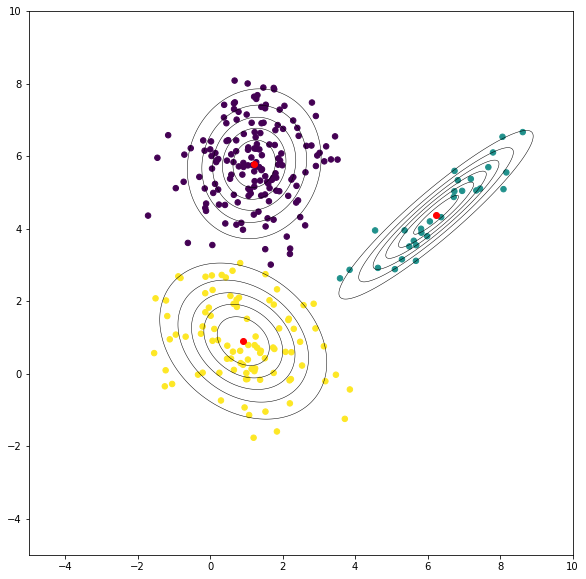

In [36]:
G.plot_clusters()